## Baseline model: simple regression
- Purpose
    - Create a baseline model for comparison
    - Baseline: Models to be compared
- the heart of one's mouth
    - Take a capture of the distribution of the target value and if it is concentrated => Log
    - Don't get frustrated because it's a baseline, because it's low performance.
- the contents
    - Check 'Target' distribution
    - Simple Linear Regression

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
#Replace 'project_id' with your BigQuery project ID
from google.cloud import bigquery
client = bigquery.Client(project='nyctaxi-demand-forecast')

### Preprocessing

In [5]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""
base_df = client.query(base_query).to_dataframe()

CPU times: user 164 ms, sys: 46.3 ms, total: 211 ms
Wall time: 2.57 s


In [6]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

In [7]:
def split_train_and_test(df, date):
  """
 Dataframe divided by train_df and test_df
  df : Time series data frame
  date : Reference point date
  """
  train_df = df[df['pickup_hour'] < date]
  test_df = df[df['pickup_hour'] >= date]
  return train_df, test_df

### Linear Regerssion
- Baseline Model

### Check Target distribution

In [8]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10170,2015-01-01 00:00:00+00:00,1,1,3,0,0,44
1,11231,2015-01-01 00:00:00+00:00,1,1,3,0,0,55
2,10040,2015-01-01 00:00:00+00:00,1,1,3,0,0,13
3,10462,2015-01-01 00:00:00+00:00,1,1,3,0,0,3
4,11225,2015-01-01 00:00:00+00:00,1,1,3,0,0,10


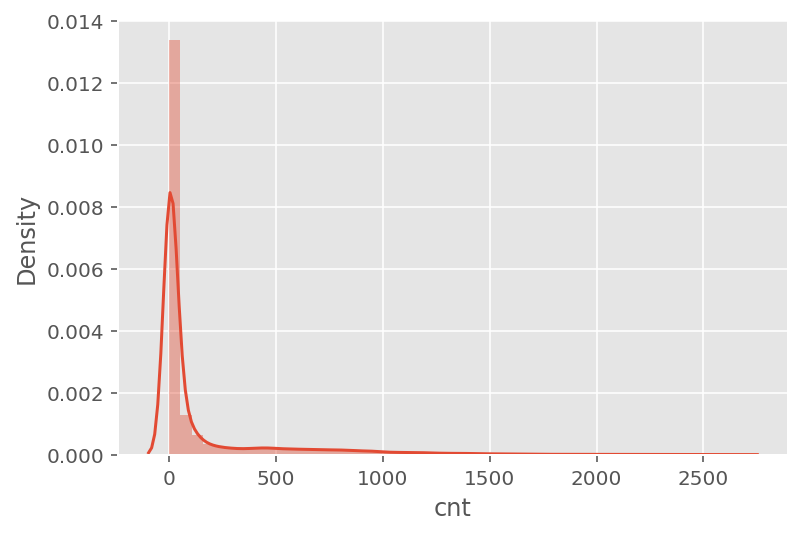

In [9]:
# Total distribution
sns.distplot(base_df['cnt']);

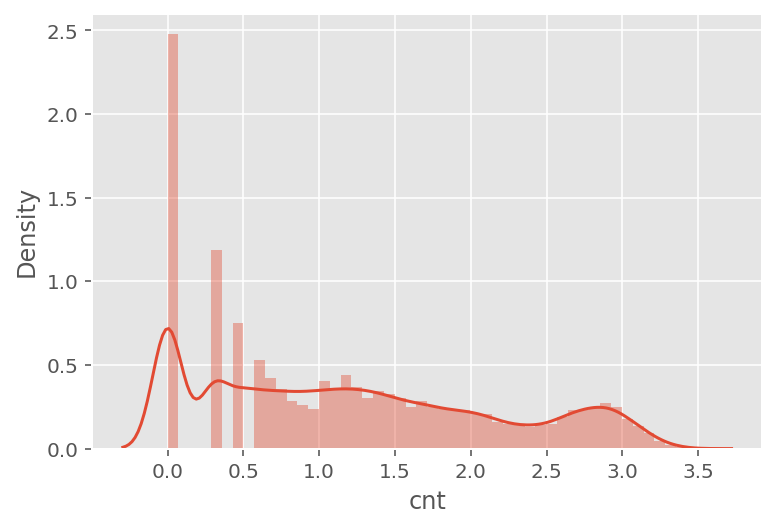

In [10]:
# Logize the overall distribution
sns.distplot(np.log10(base_df['cnt']));

### Identify as Widget

In [11]:
def visualize_dist_by_zipcode(df, log=False):
    def view_images(zip_code):
        if log:
            data = np.log10(df.loc[df['zip_code'] == str(zip_code)]['cnt'])
        else:
            data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        ax = sns.distplot(data);
        ax.set_title(f'log is {log}, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

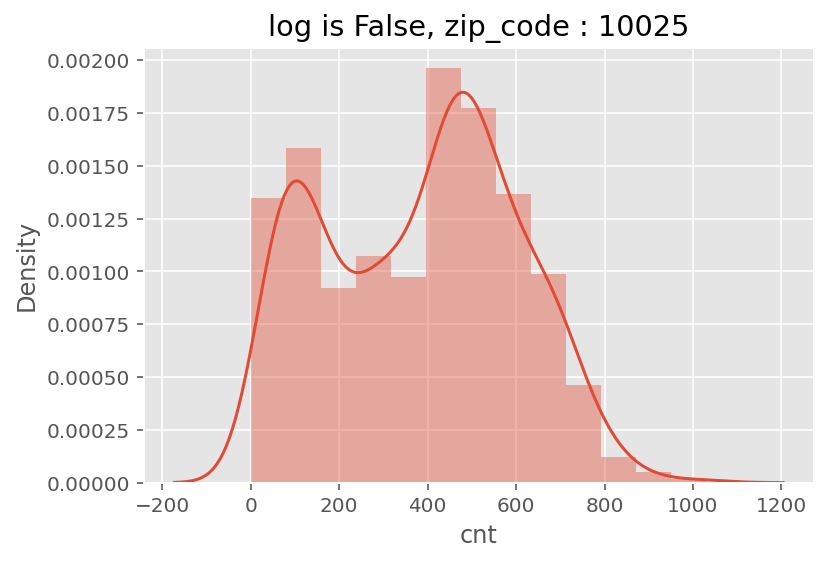

In [12]:
visualize_dist_by_zipcode(ohe_df)

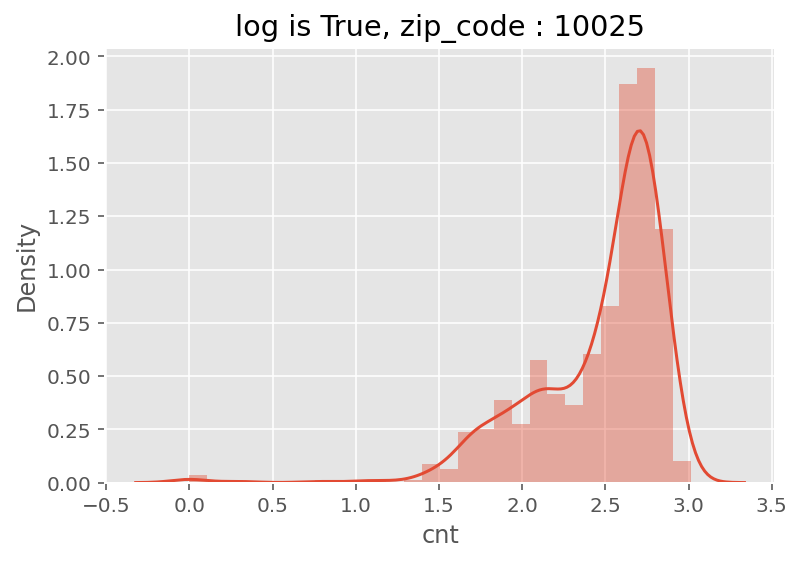

In [13]:
visualize_dist_by_zipcode(base_df, log=True)

In [14]:
def visualize_dist_by_zipcode_at_the_same_time(df):
    def view_images(zip_code):
        fig, axs = plt.subplots(ncols=2, figsize=(15,5))

        raw_data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        log_data = np.log10(raw_data)
        ax1 = sns.distplot(raw_data, ax=axs[0]);
        ax2 = sns.distplot(log_data, ax=axs[1]);
        ax1.set_title(f'log is False, zip_code : {zip_code}')
        ax2.set_title(f'log is True, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

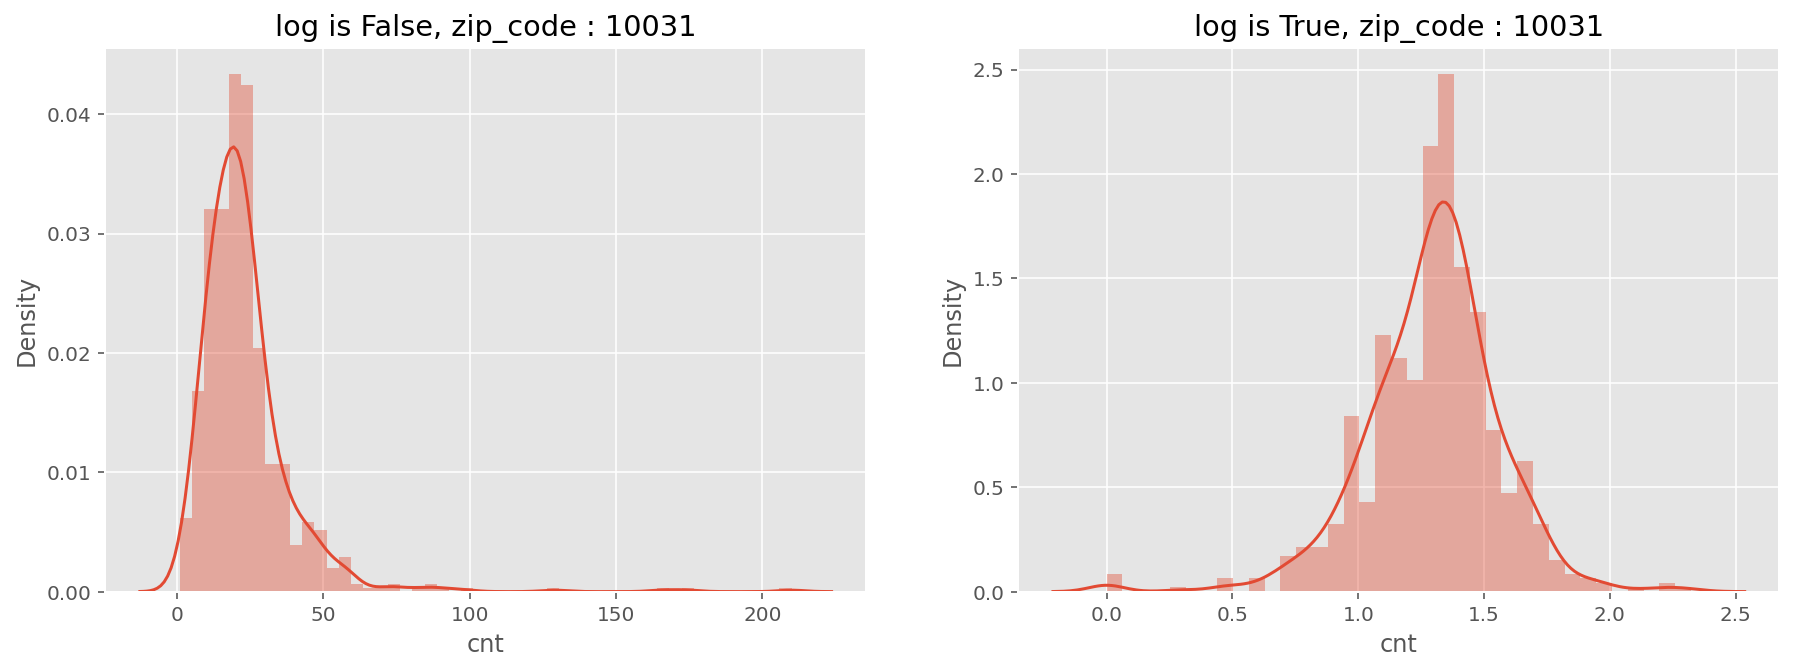

In [15]:
visualize_dist_by_zipcode_at_the_same_time(base_df)

- Create log_cnt 

In [16]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

### Split Train / Test

In [17]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [18]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65113,10044,2015-01-23 23:00:00+00:00,1,23,4,23,0,2,0.30103
65114,10128,2015-01-23 23:00:00+00:00,1,23,4,23,0,426,2.62941
65115,10012,2015-01-23 23:00:00+00:00,1,23,4,23,0,1270,3.103804
65116,10167,2015-01-23 23:00:00+00:00,1,23,4,23,0,18,1.255273
65117,10174,2015-01-23 23:00:00+00:00,1,23,4,23,0,12,1.079181


In [19]:
test_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
87015,11201,2015-01-31 23:00:00+00:00,1,31,5,23,1,190,2.278754
87016,11221,2015-01-31 23:00:00+00:00,1,31,5,23,1,16,1.20412
87017,10028,2015-01-31 23:00:00+00:00,1,31,5,23,1,571,2.756636
87018,11205,2015-01-31 23:00:00+00:00,1,31,5,23,1,50,1.69897
87019,10468,2015-01-31 23:00:00+00:00,1,31,5,23,1,1,0.0


- Delete columns I don't want to use

In [20]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [21]:
train_df.head(2)

,zip_code,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10170,1,1,3,0,0,44,1.643453
1,11231,1,1,3,0,0,55,1.740363


In [22]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [23]:
x_train = train_df.copy()
x_test = test_df.copy()

### Simple Regression
- Without One Hot Encoding

In [24]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([0.33731203, 0.50038129, 0.69968815, ..., 1.86492969, 0.84941375,
       1.48529757])

In [25]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [26]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [27]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,428.415375,126.535552,95916.687733


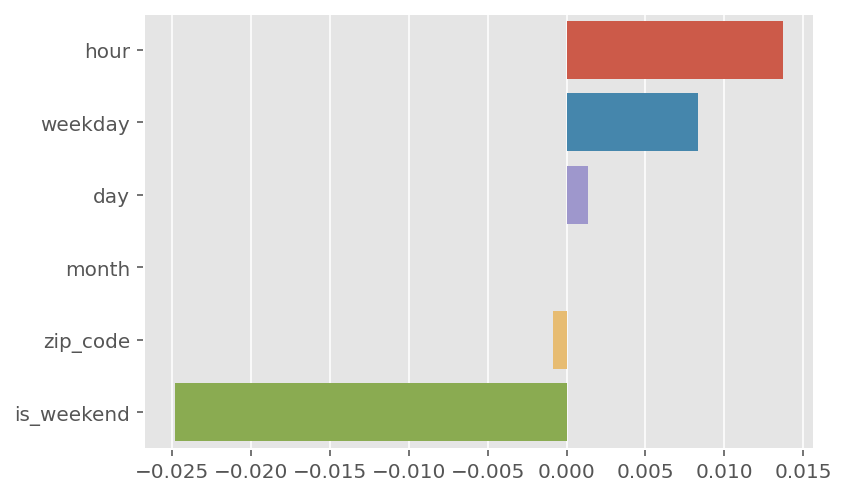

In [28]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

### One Hot Encoding

- Regression using One Hot Encoding 

In [29]:
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [30]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([-0.03704071,  0.15607452, -0.10043335, ...,  2.72512054,
        1.07194519,  0.3290863 ])

In [32]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [33]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.037041,0.918247,0.0,1
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156075,1.432434,0.90309,8
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.100433,0.793536,0.0,1
65121,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.640511,4.370293,1.146128,14
65122,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.016472,0.962782,0.30103,2


In [34]:
test_df.head(3)

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.037041,0.918247,0.0,1
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156075,1.432434,0.90309,8
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.100433,0.793536,0.0,1


In [38]:
# preprocessing for excepting inf 
test_df = test_df[np.isfinite(test_df).all(1)]

In [39]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.8782,67.013775,27049.996192


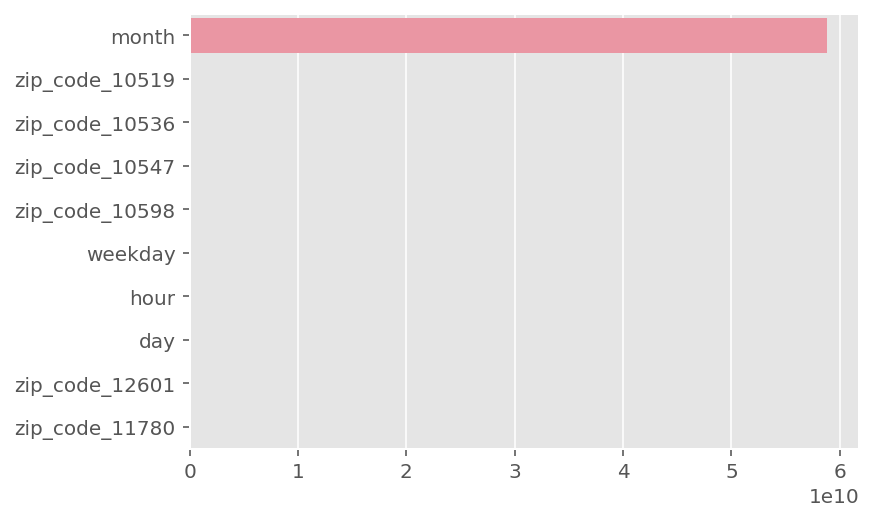

In [37]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);